# Random Forest Classification Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,
                             classification_report)

In [2]:
train_df = pd.read_csv("combined_train_with_labels.csv.gz")
test_df = pd.read_csv("combined_test_with_labels.csv.gz")

In [3]:
target = "psd_label_low_avse"
drop_cols = ["psd_label_low_avse","psd_label_high_avse","psd_label_dcr", "psd_label_lq","energy_label","id"]
X = train_df.drop(columns=drop_cols)
y = train_df[target]
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

In [5]:
rf = RandomForestClassifier(n_estimators=300,max_depth=None,max_features="sqrt",n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1:", f1_score(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_prob))

Accuracy: 0.9467163461538461
Precision: 0.9252514128989362
Recall: 0.9581706096891844
F1: 0.9414233239079306
ROC AUC: 0.9885639467511061


# LightGBM Regression Model

In [7]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
target = "energy_label"
drop_cols = ["psd_label_low_avse","psd_label_high_avse","psd_label_dcr","psd_label_lq","energy_label","id"]
X = train_df.drop(columns=drop_cols)
y = train_df[target]
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [10]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.03,n_estimators=5000,num_leaves=63,subsample=0.8,colsample_bytree=0.8,random_state=42,
    n_jobs=-1)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5335
[LightGBM] [Info] Number of data points in the train set: 832000, number of used features: 23
[LightGBM] [Info] Start training from score 638.761951


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.03
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [11]:
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

Train RMSE: 13.149949635419823
Test RMSE: 30.915082297963462
Train R2: 0.9996155637439068
Test R2: 0.9978672888349249
Test MAE: 6.770113429366994


In [12]:
drop_cols_reg = ["psd_label_low_avse","psd_label_high_avse","psd_label_dcr","psd_label_lq","energy_label","id"]
X_test_ext = test_df.drop(columns=drop_cols_reg)
X_test_ext = X_test_ext.replace([np.inf, -np.inf], np.nan)
X_test_ext = X_test_ext.fillna(X_train.median())     
X_test_ext = X_test_ext[X_train.columns]             

In [13]:
y_pred_ext = lgb_model.predict(X_test_ext)
y_true_ext = test_df["energy_label"].values

# Plot 1 - True energy spectrum vs Predicted energy Spectrum

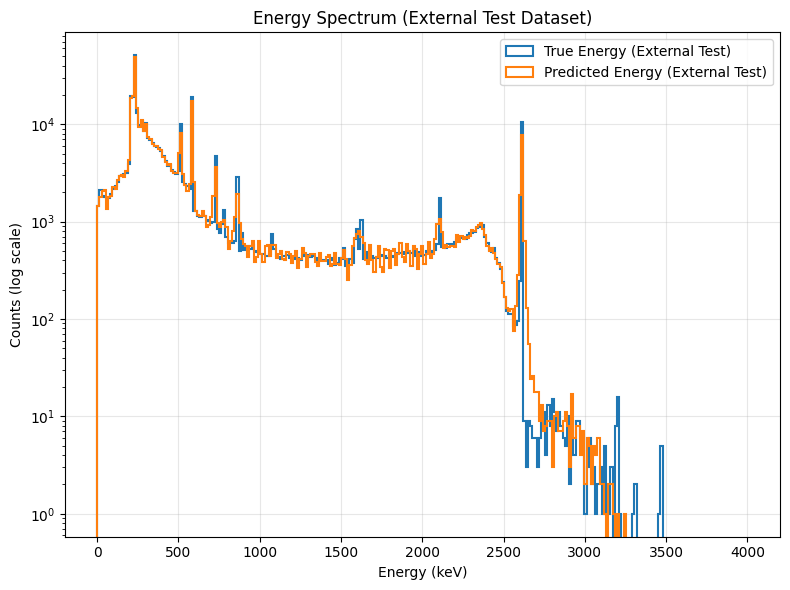

In [14]:
bins = np.linspace(0, 4000, 300)
plt.figure(figsize=(8,6))
plt.hist(y_true_ext, bins=bins, histtype="step", linewidth=1.5, label="True Energy (External Test)")
plt.hist(y_pred_ext, bins=bins, histtype="step", linewidth=1.5, label="Predicted Energy (External Test)")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts (log scale)")
plt.title("Energy Spectrum (External Test Dataset)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
true_counts, _ = np.histogram(y_true_ext, bins=bins)
pred_counts, _ = np.histogram(y_pred_ext, bins=bins)

In [28]:
true_counts_norm = true_counts / true_counts.sum()
pred_counts_norm = pred_counts / pred_counts.sum()
iou_full_norm = np.minimum(true_counts_norm, pred_counts_norm).sum() / np.maximum(true_counts_norm, pred_counts_norm).sum()
print("Normalized IoU (Full):", iou_full_norm)

Normalized IoU (Full): 0.9089386622755664


# Plot 2 - True energy spectrum (cut with true psd labels) vs Predicted Energy Spectrum (cut with predicted labels)

In [15]:
pred_labels = pd.read_csv("/Users/prithvikochhar/Documents/GitHub/Majorana-Neutrino-Hunt/extracted_features_csv_files/combined_classfication_preds_files/combined_classification_predictions.csv")

In [16]:
pred_labels = pred_labels[(pred_labels['pred_low_avse'] == 1) & (pred_labels['pred_high_avse'] == 1) & (pred_labels['pred_dcr'] == 1) 
                          & (pred_labels['pred_lq'] == 1)]

In [17]:
merged = test_df.merge(pred_labels, on="id", how="inner")

In [18]:
pred_cut = merged[(merged['pred_low_avse'] == 1) & (merged['pred_high_avse'] == 1) & (merged['pred_dcr'] == 1)
                     & (merged['pred_lq'] == 1)]

In [19]:
X_pred_cut = pred_cut.drop(columns=drop_cols_reg)
X_pred_cut = X_pred_cut.replace([np.inf, -np.inf], np.nan)
X_pred_cut = X_pred_cut.fillna(X_train.median())
X_pred_cut = X_pred_cut[X_train.columns]
y_pred_cut = lgb_model.predict(X_pred_cut)

In [20]:
true_cut = test_df[(test_df["psd_label_low_avse"] == 1) & (test_df["psd_label_high_avse"] == 1) & (test_df["psd_label_dcr"] == 1) &
    (test_df["psd_label_lq"] == 1)]
y_true_cut = true_cut["energy_label"].values

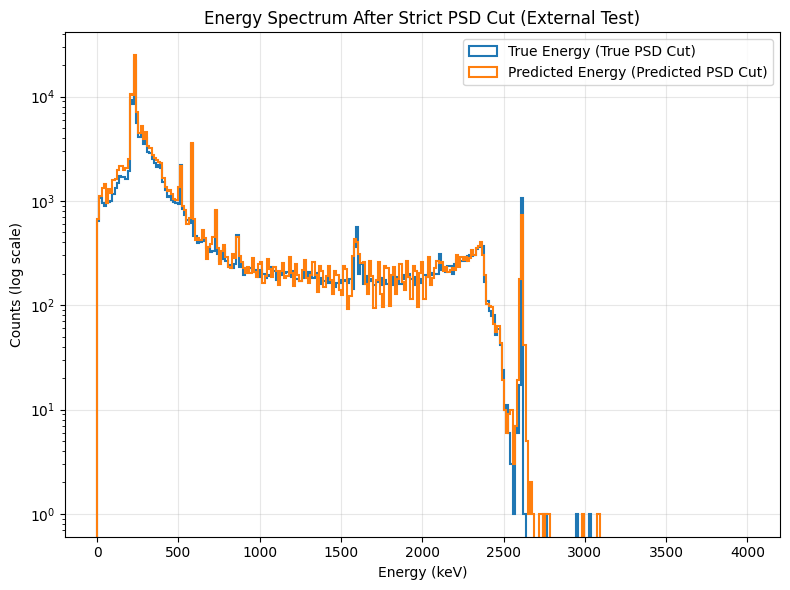

In [21]:
plt.figure(figsize=(8,6))
plt.hist(y_true_cut, bins=bins, histtype="step", linewidth=1.5, label="True Energy (True PSD Cut)")
plt.hist(y_pred_cut, bins=bins, histtype="step", linewidth=1.5, label="Predicted Energy (Predicted PSD Cut)")
plt.yscale("log")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts (log scale)")
plt.title("Energy Spectrum After Strict PSD Cut (External Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
true_cut_counts, _ = np.histogram(y_true_cut, bins=bins)
pred_cut_counts, _ = np.histogram(y_pred_cut, bins=bins)

In [29]:
true_cut_counts_norm = true_cut_counts / true_cut_counts.sum()
pred_cut_counts_norm = pred_cut_counts / pred_cut_counts.sum()
iou_cut_norm = np.minimum(true_cut_counts_norm, pred_cut_counts_norm).sum() / np.maximum(true_cut_counts_norm, pred_cut_counts_norm).sum()
print("Normalized IoU (Cut):", iou_cut_norm)

Normalized IoU (Cut): 0.9212994959012702
